In [1]:
import os
import sys
import numpy as np
import pandas as pd
from Bio import SeqIO
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
os.getcwd()
os.listdir()

['.Rhistory',
 'js1_bi.csv',
 'BreakPointDistance.csv',
 'Bipartite_graph.ipynb',
 'Junction_Sequences_NTRK1_nonCRC_4_19_20_deid.xlsx',
 '.DS_Store',
 'Table1.rds',
 'data_Junction_Regions_CRC_4_19_20_deid.fa',
 'nonCRC_Table1.pkl',
 'Fusion_Gene_ NTRK1_partners.ipynb',
 'Genome Screenshots',
 'Window_boxplot_J2.ipynb',
 'Fusion_Gene_nonCRC.ipynb',
 'Window_lineplot.ipynb',
 'Junction_Sequences_CRC_4_19_20_deid.xlsx',
 'js1_count.pkl',
 'Bed_files_for_USCS_plot.ipynb',
 '.RData',
 'nonCRC_gene1_bed',
 'CRC_gene1_bed',
 'Table1.pkl',
 'CRC_gene2_bed',
 'Window_boxplot_J1.ipynb',
 '.ipynb_checkpoints',
 'humanFreq.png',
 'CRC_gene1_bed.zip',
 'Fusion_Gene_R.ipynb',
 'Fusion_Gene_CRC.ipynb',
 'MSS_MSI_review.pptx',
 'Re__Windows_in_oncogenic_gene..zip',
 'Fusion_Gene_R.R',
 'data_Junction_Regions_CRC_4_19_20_deid_J2.fa',
 'CeCe_Proj']

# My functions

In [2]:
# GC content related functions

def cound_mononucleotide(i):
    A_ct = i.count('A') + i.count('a')
    T_ct = i.count('T') + i.count('t')
    C_ct = i.count('C') + i.count('c')
    G_ct = i.count('G') + i.count('g')
    tmp = {'A':A_ct, 'T':T_ct, 'C':C_ct,'G':G_ct}
    return tmp

def count_mono_series(indexed): #takes in a series, returns a dictionary
    save = {}
    for i in range(len(indexed)):
        save[indexed.index[i]] = cound_mononucleotide(indexed[i])
    return save

def my_referse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return "".join(complement.get(base, base) for base in reversed(seq))

def combine_rc_percentage(dg): #takes in a dataframe, returns a data frame
    df = dg.copy()
    df['count'] = df.sum(axis=1)
    cols_rest = list(df.columns)
    cols_1 = []
    cols_2 = []
    for i in df.columns:
        reverse_tmp = my_referse_complement(i)
        if reverse_tmp in list(df.columns):
            cols_rest.remove(i)
            if reverse_tmp not in cols_1:
                cols_1.append(i)
                cols_2.append(reverse_tmp)   
    dt = pd.DataFrame()
    #cols_c = []
    for i,j in zip(cols_1,cols_2):
        if i==j:
            #cols_c.append(i)
            dt[i] = df[i]/df['count']
        else:
            k = i+"+"+j
            #cols_c.append(k)
            dt[k] = (df[i]+df[j])/df['count']           
    dt = pd.concat([dt, df[cols_rest]], axis=1)
    return dt

#vactorized String Operations: https://jakevdp.github.io/PythonDataScienceHandbook/03.10-working-with-strings.html
def GC_percentage_series(series): #takes in a series returns a series
    ser = series.str.upper()
    total = ser.str.len()
    gc_count = ser.str.count("C") + ser.str.count("G") + ser.str.count("c") + ser.str.count("g")
    gc_percent = gc_count/total
    return gc_percent
    

# Extract info from sequence ID

def Split_IDs(df):
    dt = df.copy()
    # Drop MSI ambiguous records
    dt = dt[ ~ dt["IDs"].str.endswith('MSI')] # inverting (~) boolean mask
    # Split - Vectorized string functions for Series and Index
    dt[['Chr','Pos','ID1', 'ID2','MSIstatus','Junction','Gene']] = dt.IDs.str.split(':', expand=True)
    dt = dt.drop(columns = 'IDs')
    return dt

# Window related functions

def roughly_any_bp(df, wing=2, centre=51):
    tmp = df.copy()
    bp = wing*2 + 1
    tmp["{}bp".format(bp)] =tmp["50+1+50"].str.slice(centre-wing-1, centre+wing)
    tmp.drop(tmp.columns[0],axis=1,inplace = True) #drop '50+1+50'
    return tmp
def roughly_many_bp(df, wings=(0,2,10), centre=51):
    tmp = df.copy()
    for wing in wings:
        bp = wing*2 + 1
        tmp[str(bp)]=tmp["50+1+50"].str.slice(centre-wing-1, centre+wing)
    tmp.drop(tmp.columns[0],axis=1,inplace = True) #drop '50+1+50'
    return tmp

def roughly_any_bp_GC(df, wing=2, centre=51):
    tmp = df.copy()
    bp = wing*2 + 1
    tmp["{}bp".format(bp)] = GC_percentage_series(tmp["50+1+50"].str.slice(centre-wing-1, centre+wing))
    tmp.drop(tmp.columns[0],axis=1,inplace = True) #drop '50+1+50'
    return tmp
def roughly_many_bp_GC(df, wings=(0,2,10), centre=51):
    tmp = df.copy()
    for wing in wings:
        bp = wing*2 + 1
        tmp[str(bp)] = GC_percentage_series(tmp["50+1+50"].str.slice(centre-wing-1, centre+wing))
    tmp.drop(tmp.columns[0],axis=1,inplace = True) #drop '50+1+50'
    return tmp

# Build windows and get GC content

## Junction 1 (J1)

In [3]:
with open("data_Junction_Regions_CRC_4_19_20_deid.fa") as handle:
    Seqs = pd.Series([str(record.seq) for record in SeqIO.parse(handle,"fasta")])
with open("data_Junction_Regions_CRC_4_19_20_deid.fa") as handle:
    IDs = pd.Series([record.id for record in SeqIO.parse(handle,"fasta")])
J1_tbl = pd.DataFrame({'IDs': IDs, "50+1+50": Seqs})
J1_tbl.head()

,IDs,50+1+50
0,chr10:43611864-43611964:XRN:6SJTT7:MSI-H:J1:G1,CTGCCCAGGGCAGAGACAGGCAGCGTTGCCGCTGGCTCAGATGACA...
1,chr7:138268017-138268117:XRN:6SJTT7:MSI-H:J1:G2,AAGAAAAAAATCTAGATGATTAAGAGGAAATATGTGAAGACAAGTT...
2,chr7:140489379-140489479:XRN:DNF6WD:MSS:J1:G1,AACTTTCCATTCTTGAGAGCTTACAATCTCATGGGAAGTAAGATGC...
3,chr7:138253042-138253142:XRN:DNF6WD:MSS:J1:G2,ATTTTTAGTAGAGACTGGGTTTCACCGTGTTAGCCAGGATGGTCTC...
4,chr10:43611746-43611846:XRN:E3F52H:MSI,GGGCAGGGGTCAGGGGAGACAGTAGACCAGGAACCAGAGAGGGTCG...


In [4]:
splitJ1 = Split_IDs(J1_tbl)
splitJ1.head()

,50+1+50,Chr,Pos,ID1,ID2,MSIstatus,Junction,Gene
0,CTGCCCAGGGCAGAGACAGGCAGCGTTGCCGCTGGCTCAGATGACA...,chr10,43611864-43611964,XRN,6SJTT7,MSI-H,J1,G1
1,AAGAAAAAAATCTAGATGATTAAGAGGAAATATGTGAAGACAAGTT...,chr7,138268017-138268117,XRN,6SJTT7,MSI-H,J1,G2
2,AACTTTCCATTCTTGAGAGCTTACAATCTCATGGGAAGTAAGATGC...,chr7,140489379-140489479,XRN,DNF6WD,MSS,J1,G1
3,ATTTTTAGTAGAGACTGGGTTTCACCGTGTTAGCCAGGATGGTCTC...,chr7,138253042-138253142,XRN,DNF6WD,MSS,J1,G2
8,GACCTGTTTCTCCCAGGCCTGCCCTTTGATTTCGGGTTCTACTCGC...,chr1,156843296-156843396,XRN,AFAEVN,MSI-H,J1,G1


In [5]:
J1_bps = roughly_many_bp(splitJ1)
J1_bps.head()

,Chr,Pos,ID1,ID2,MSIstatus,Junction,Gene,1,5,21
0,chr10,43611864-43611964,XRN,6SJTT7,MSI-H,J1,G1,G,CGGTT,ATGACAGCCGGTTCTCTGCAC
1,chr7,138268017-138268117,XRN,6SJTT7,MSI-H,J1,G2,C,TTCAT,CAAGTTTTTTCATTAAAAATA
2,chr7,140489379-140489479,XRN,DNF6WD,MSS,J1,G1,A,ACATT,AGATGCACACATTGGAAGTAA
3,chr7,138253042-138253142,XRN,DNF6WD,MSS,J1,G2,T,TCTCC,GGTCTCAATCTCCTAAACTCG
8,chr1,156843296-156843396,XRN,AFAEVN,MSI-H,J1,G1,C,TGCCC,ACTCGCTTTGCCCGTGGACTT


In [82]:
J1_bps["5"].head()

0    CGGTT
1    TTCAT
2    ACATT
3    TCTCC
8    TGCCC
Name: 5, dtype: object

In [70]:
ser = J1_bps["5"]
ser.str.len()
ser.str.count("G")
GC_percentage_series(ser)

0    0.6
1    0.2
2    0.2
3    0.6
8    0.8
Name: 5, dtype: float64

In [7]:
gc1521 = roughly_many_bp_GC(splitJ1)
gc1521.head(3)

,Chr,Pos,ID1,ID2,MSIstatus,Junction,Gene,1,5,21
0,chr10,43611864-43611964,XRN,6SJTT7,MSI-H,J1,G1,1.0,0.6,0.571429
1,chr7,138268017-138268117,XRN,6SJTT7,MSI-H,J1,G2,1.0,0.2,0.142857
2,chr7,140489379-140489479,XRN,DNF6WD,MSS,J1,G1,0.0,0.2,0.380952


In [6]:
roughly_many_bp_GC(splitJ1, wings = range(0,11)).head(3)

,Chr,Pos,ID1,ID2,MSIstatus,Junction,Gene,1,3,5,7,9,11,13,15,17,19,21
0,chr10,43611864-43611964,XRN,6SJTT7,MSI-H,J1,G1,1.0,0.666667,0.6,0.714286,0.666667,0.636364,0.615385,0.600000,0.647059,0.578947,0.571429
1,chr7,138268017-138268117,XRN,6SJTT7,MSI-H,J1,G2,1.0,0.333333,0.2,0.142857,0.111111,0.090909,0.076923,0.133333,0.117647,0.105263,0.142857
2,chr7,140489379-140489479,XRN,DNF6WD,MSS,J1,G1,0.0,0.333333,0.2,0.428571,0.444444,0.454545,0.461538,0.466667,0.411765,0.421053,0.380952


## Junction 2 (J2)

In [3]:
with open("data_Junction_Regions_CRC_4_19_20_deid_J2.fa") as handle:
    Seqs = pd.Series([str(record.seq) for record in SeqIO.parse(handle,"fasta")])
with open("data_Junction_Regions_CRC_4_19_20_deid_J2.fa") as handle:
    IDs = pd.Series([record.id for record in SeqIO.parse(handle,"fasta")])
J2_tbl = pd.DataFrame({'IDs': IDs, "50+1+50": Seqs})
J2_tbl.head()

,IDs,50+1+50
0,chr7:140489380-140489480:XRN:DNF6WD:MSS:J2:G1,ACTTTCCATTCTTGAGAGCTTACAATCTCATGGGAAGTAAGATGCA...
1,chr7:138253043-138253143:XRN:DNF6WD:MSS:J2:G2,TTTTTAGTAGAGACTGGGTTTCACCGTGTTAGCCAGGATGGTCTCA...
2,chr10:43607709-43607809:XRN:E3F52H:MSI,GCGATGGCACCGGTGGAAACGGGGTCCTGGGGCCCTGCCAGCCTGG...
3,chr10:51587649-51587749:XRN:E3F52H:MSI,GATGTTTTATTAGCAAACATGAAAACATTAATCTCCTTCTGCATCT...
4,chr1:156843298-156843398:XRN:AFAEVN:MSI-H:J2:G1,CCTGTTTCTCCCAGGCCTGCCCTTTGATTTCGGGTTCTACTCGCTT...


In [4]:
splitJ2 = Split_IDs(J2_tbl)
J2_bps = roughly_many_bp(splitJ2)
J2gc1521 = roughly_many_bp_GC(splitJ2)

In [5]:
J2gc1521.head(3)

,Chr,Pos,ID1,ID2,MSIstatus,Junction,Gene,1,5,21
0,chr7,140489380-140489480,XRN,DNF6WD,MSS,J2,G1,0.0,0.4,0.428571
1,chr7,138253043-138253143,XRN,DNF6WD,MSS,J2,G2,1.0,0.6,0.428571
4,chr1,156843298-156843398,XRN,AFAEVN,MSI-H,J2,G1,1.0,0.8,0.571429


In [6]:
roughly_many_bp_GC(splitJ2, wings = range(0,11)).head(3)

,Chr,Pos,ID1,ID2,MSIstatus,Junction,Gene,1,3,5,7,9,11,13,15,17,19,21
0,chr7,140489380-140489480,XRN,DNF6WD,MSS,J2,G1,0.0,0.000000,0.4,0.428571,0.444444,0.363636,0.461538,0.466667,0.411765,0.368421,0.428571
1,chr7,138253043-138253143,XRN,DNF6WD,MSS,J2,G2,1.0,0.666667,0.6,0.428571,0.333333,0.272727,0.384615,0.333333,0.411765,0.421053,0.428571
4,chr1,156843298-156843398,XRN,AFAEVN,MSI-H,J2,G1,1.0,1.000000,0.8,0.857143,0.777778,0.636364,0.615385,0.600000,0.588235,0.631579,0.571429


# Group by Gene and lineplot by MSIstatus

## Junction 1 (J1)

In [8]:
grouped = gc1521.groupby(["Gene","MSIstatus"])
for name, group in grouped:
    print(name)

('G1', 'MSI-H')
('G1', 'MSS')
('G2', 'MSI-H')
('G2', 'MSS')


In [9]:
grouped['21'].agg([np.mean, np.std, np.size, np.sum])

mean       std   size        sum
Gene MSIstatus                                      
G1   MSI-H      0.546584  0.127165   92.0  50.285714
     MSS        0.473352  0.157285  151.0  71.476190
G2   MSI-H      0.484472  0.133499   92.0  44.571429
     MSS        0.430148  0.145730  151.0  64.952381

In [10]:
type(grouped.agg([np.mean, np.std]))

pandas.core.frame.DataFrame

In [11]:
grouped.agg([np.mean, np.std]).index

MultiIndex(levels=[['G1', 'G2'], ['MSI-H', 'MSS']],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]],
           names=['Gene', 'MSIstatus'])

In [67]:
to_plot = grouped.agg(np.mean)#.reset_index()
to_plot

1         5        21
Gene MSIstatus                              
G1   MSI-H      0.565217  0.534783  0.546584
     MSS        0.430464  0.491391  0.473352
G2   MSI-H      0.489130  0.482609  0.484472
     MSS        0.377483  0.419868  0.430148

In [68]:
to_plot.columns.name = 'bp'
to_plot = to_plot.stack()
to_plot.name = "GCcontent"
to_plot = to_plot.reset_index()
to_plot['bp'] = pd.to_numeric(to_plot['bp']) # convert str to numeric
to_plot

,Gene,MSIstatus,bp,GCcontent
0,G1,MSI-H,1,0.565217
1,G1,MSI-H,5,0.534783
2,G1,MSI-H,21,0.546584
3,G1,MSS,1,0.430464
4,G1,MSS,5,0.491391
5,G1,MSS,21,0.473352
6,G2,MSI-H,1,0.489130
7,G2,MSI-H,5,0.482609
8,G2,MSI-H,21,0.484472
9,G2,MSS,1,0.377483


In [60]:
type(to_plot.bp[0])

numpy.int64

,pig,horse
1990,20,4
1997,18,25
2003,489,281
2009,675,600
2014,1776,1900


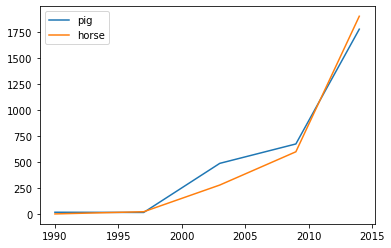

In [50]:
df = pd.DataFrame({
   'pig': [20, 18, 489, 675, 1776],
   'horse': [4, 25, 281, 600, 1900]
   }, index=[1990, 1997, 2003, 2009, 2014])
lines = df.plot.line()
df

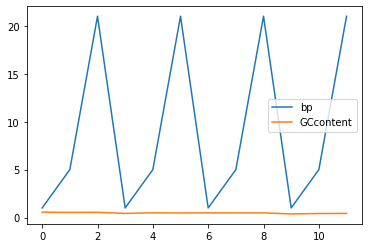

In [65]:
to_plot.plot(by = 'bp')

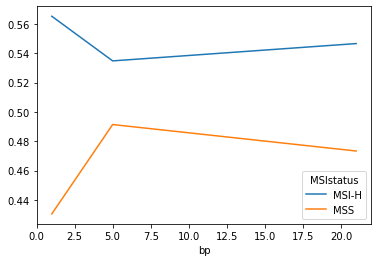

In [82]:
to_plot_by_MSI = to_plot.iloc[0:6,:].pivot(index = 'bp', columns = 'MSIstatus', values = 'GCcontent')
to_plot_by_MSI.plot.line()

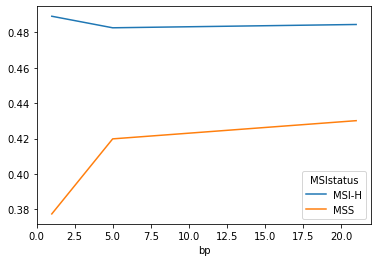

In [100]:
to_plot.iloc[6:,:].pivot(index = 'bp', columns = 'MSIstatus', values = 'GCcontent').plot.line()

## Junction 2 (J2)

# Plot contiue

## Junction 1 (J1)

In [94]:
gccontinue = roughly_many_bp_GC(splitJ1, wings = range(0,50)).groupby(["Gene","MSIstatus"]).agg(np.mean)
gccontinue.T.head()

Gene             G1                  G2          
MSIstatus     MSI-H       MSS     MSI-H       MSS
1          0.565217  0.430464  0.489130  0.377483
3          0.561594  0.481236  0.500000  0.408389
5          0.534783  0.491391  0.482609  0.419868
7          0.535714  0.494797  0.486025  0.422895
9          0.538647  0.485651  0.492754  0.431935

In [95]:
# https://support.sisense.com/hc/en-us/community/posts/360037984913-Pivoting-and-Melting-Dataframes
# https://pandas-docs.github.io/pandas-docs-travis/user_guide/reshaping.html
gccontinue.columns.name = "bp" # columns in a dataframe can also carry a name.
gcstack = gccontinue.stack()
gcstack.name = "GCcontent" # set series name
gcstack

Gene  MSIstatus  bp
G1    MSI-H      1     0.565217
                 3     0.561594
                 5     0.534783
                 7     0.535714
                 9     0.538647
                 11    0.541502
                 13    0.539298
                 15    0.541304
                 17    0.544757
                 19    0.546911
                 21    0.546584
                 23    0.541115
                 25    0.546087
                 27    0.539855
                 29    0.540855
                 31    0.539621
                 33    0.538867
                 35    0.541925
                 37    0.544947
                 39    0.542642
                 41    0.544274
                 43    0.541962
                 45    0.545411
                 47    0.548104
                 49    0.549911
                 51    0.549659
                 53    0.550451
                 55    0.550593
                 57    0.549962
                 59    0.548084
                    

In [96]:
print(type(gcstack))
print(type(gcstack.reset_index()))
J1_gclong = gcstack.reset_index() # convert multiIndex series to a dataframe
J1_gclong['bp'] = pd.to_numeric(J1_gclong['bp']) # convert str to numeric

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [90]:
print(type(J1_gclong))
gcstack.index

<class 'pandas.core.frame.DataFrame'>


MultiIndex(levels=[['G1', 'G2'], ['MSI-H', 'MSS'], ['1', '3', '5']],
           labels=[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]],
           names=['Gene', 'MSIstatus', 'bp'])

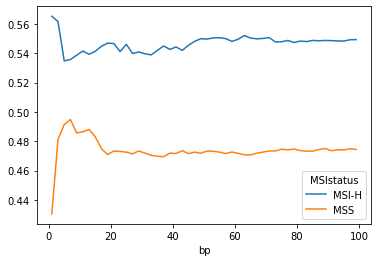

In [97]:
J1_gclong[J1_gclong["Gene"] == 'G1'].pivot(index = 'bp', columns = 'MSIstatus', values = 'GCcontent').plot.line()

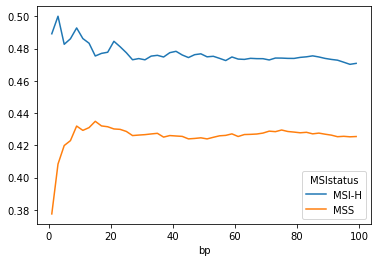

In [98]:
J1_gclong[J1_gclong["Gene"] == 'G2'].pivot(index = 'bp', columns = 'MSIstatus', values = 'GCcontent').plot.line()

## Junction 2 (J2)

In [1]:
J2_gccontinue = roughly_many_bp_GC(splitJ2, wings = range(0,50)).groupby(["Gene","MSIstatus"]).agg(np.mean)
J2_gccontinue.columns.name = "bp" # columns in a dataframe can also carry a name.
J2_gcstack = J2_gccontinue.stack()
J2_gcstack.name = "GCcontent" # set series name
J2_gcstack

NameError: name 'roughly_many_bp_GC' is not defined

In [11]:
J2_gclong = J2_gcstack.reset_index() # convert multiIndex series to a dataframe
J2_gclong['bp'] = pd.to_numeric(J2_gclong['bp']) # convert str to numeric

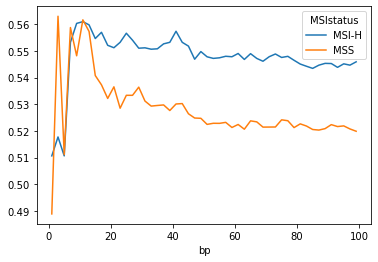

In [12]:
J2_gclong[J2_gclong["Gene"] == 'G1'].pivot(index = 'bp', columns = 'MSIstatus', values = 'GCcontent').plot.line()

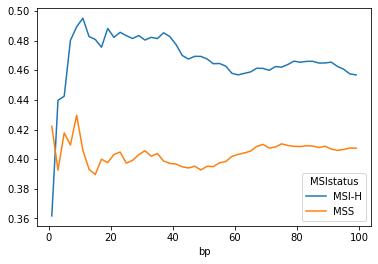

In [14]:
J2_gclong[J2_gclong["Gene"] == 'G2'].pivot(index = 'bp', columns = 'MSIstatus', values = 'GCcontent').plot.line()

# Plot GCcontent at individual base

## Junction 1 (J1)

In [3]:
records = list(SeqIO.parse("data_Junction_Regions_CRC_4_19_20_deid.fa","fasta"))
len(records)

490

In [15]:
foo = records[0]
foo

SeqRecord(seq=Seq('CTGCCCAGGGCAGAGACAGGCAGCGTTGCCGCTGGCTCAGATGACAGCCGGTTC...GCC', SingleLetterAlphabet()), id='chr10:43611864-43611964:XRN:6SJTT7:MSI-H:J1:G1', name='chr10:43611864-43611964:XRN:6SJTT7:MSI-H:J1:G1', description='chr10:43611864-43611964:XRN:6SJTT7:MSI-H:J1:G1', dbxrefs=[])

In [27]:
dir(foo) # get all attributes

['__add__',
 '__bool__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__le___',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_per_letter_annotations',
 '_seq',
 '_set_per_letter_annotations',
 '_set_seq',
 'annotations',
 'dbxrefs',
 'description',
 'features',
 'format',
 'id',
 'letter_annotations',
 'lower',
 'name',
 'reverse_complement',
 'seq',
 'translate',
 'upper']

In [20]:
foo.name == foo.id

True

In [4]:
J1_IDs = list(SeqIO.index("data_Junction_Regions_CRC_4_19_20_deid.fa","fasta"))
print(J1_IDs[0])
pd.Series(J1_IDs).head()

chr10:43611864-43611964:XRN:6SJTT7:MSI-H:J1:G1


0     chr10:43611864-43611964:XRN:6SJTT7:MSI-H:J1:G1
1    chr7:138268017-138268117:XRN:6SJTT7:MSI-H:J1:G2
2      chr7:140489379-140489479:XRN:DNF6WD:MSS:J1:G1
3      chr7:138253042-138253142:XRN:DNF6WD:MSS:J1:G2
4             chr10:43611746-43611846:XRN:E3F52H:MSI
dtype: object

In [5]:
J1_df = pd.DataFrame(SeqIO.parse("data_Junction_Regions_CRC_4_19_20_deid.fa","fasta"))
J1_df.insert(0, "IDs", pd.Series(J1_IDs)) # add "ID" column to the left
J1_df = Split_IDs(J1_df)
J1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,Chr,Pos,ID1,ID2,MSIstatus,Junction,Gene
0,C,T,G,C,C,C,A,G,G,G,...,G,C,C,chr10,43611864-43611964,XRN,6SJTT7,MSI-H,J1,G1
1,A,A,G,A,A,A,A,A,A,A,...,A,A,C,chr7,138268017-138268117,XRN,6SJTT7,MSI-H,J1,G2
2,A,A,C,T,T,T,C,C,A,T,...,T,A,T,chr7,140489379-140489479,XRN,DNF6WD,MSS,J1,G1
3,A,T,T,T,T,T,A,G,T,A,...,T,T,T,chr7,138253042-138253142,XRN,DNF6WD,MSS,J1,G2
8,G,A,C,C,T,G,T,T,T,C,...,A,C,C,chr1,156843296-156843396,XRN,AFAEVN,MSI-H,J1,G1


In [6]:
J1_bases = J1_df.iloc[:,np.r_[0:101,104:106,107]] # np.r_[] simply builts an array
J1_bases.head()

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,ID2,MSIstatus,Gene
0,C,T,G,C,C,C,A,G,G,G,...,T,C,T,T,G,C,C,6SJTT7,MSI-H,G1
1,A,A,G,A,A,A,A,A,A,A,...,T,C,C,C,A,A,C,6SJTT7,MSI-H,G2
2,A,A,C,T,T,T,C,C,A,T,...,A,G,A,A,T,A,T,DNF6WD,MSS,G1
3,A,T,T,T,T,T,A,G,T,A,...,T,T,T,T,T,T,T,DNF6WD,MSS,G2
8,G,A,C,C,T,G,T,T,T,C,...,C,C,T,G,A,C,C,AFAEVN,MSI-H,G1


In [7]:
grouped = J1_bases.groupby(["Gene","MSIstatus"])
for name, group in grouped:
    print(name)
    print("_".join(name)) # join group name as string

('G1', 'MSI-H')
G1_MSI-H
('G1', 'MSS')
G1_MSS
('G2', 'MSI-H')
G2_MSI-H
('G2', 'MSS')
G2_MSS


### Gene1 (G1)

In [8]:
J1_bases_G1_MSI = grouped.get_group(('G1', 'MSI-H'))
J1_bases_G1_MSI.head()

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,ID2,MSIstatus,Gene
0,C,T,G,C,C,C,A,G,G,G,...,T,C,T,T,G,C,C,6SJTT7,MSI-H,G1
8,G,A,C,C,T,G,T,T,T,C,...,C,C,T,G,A,C,C,AFAEVN,MSI-H,G1
10,C,T,C,C,C,T,C,C,A,G,...,C,T,G,G,T,G,C,MPPMPA,MSI-H,G1
12,A,C,A,G,T,C,C,C,G,G,...,G,C,T,G,G,C,T,30NP36,MSI-H,G1
14,C,T,C,A,A,C,C,A,G,C,...,T,G,G,A,C,A,A,JPE87T,MSI-H,G1


In [9]:
J1_bases_G1_MSI.iloc[:,0:101].T.head()

,0,8,10,12,14,16,18,20,22,24,...,170,172,174,176,178,180,182,184,186,188
0,C,G,C,A,C,T,C,T,T,A,...,A,T,A,T,A,C,C,T,G,C
1,T,A,T,C,T,C,C,T,G,G,...,A,G,T,C,A,T,C,G,G,T
2,G,C,C,A,C,A,C,T,G,C,...,A,A,A,C,A,C,A,T,T,G
3,C,C,C,G,A,A,C,C,T,C,...,T,A,T,C,T,C,A,A,T,G
4,C,T,C,T,A,C,T,G,G,A,...,A,A,C,T,T,A,A,T,T,G


In [10]:
# 注意 str.join() 与 str.cat() 的区别
pos1 = J1_bases_G1_MSI.iloc[:,0].str.cat()
pos1

'CGCACTCTTAACCGGATTCCAGACTGACCTCGGGGCGGCCTATAGTATAGACCGAGACGAGCGGAGTTTGAGGGCTAATCGGATATACCTGC'

In [11]:
cat_column = J1_bases_G1_MSI.iloc[:,0:101].apply(lambda x: x.str.cat(), axis = 0)
cat_column.head()

0    CGCACTCTTAACCGGATTCCAGACTGACCTCGGGGCGGCCTATAGT...
1    TATCTCCTGGAGTAAGCCCCCTCCCACCTTGTGGGTCGAATAACCC...
2    GCCACACTGCACGGGGTTCCCCATCCCGGTCGACCGGGAAGAAATC...
3    CCCGAACCTCGTACAGTTAATTGGCGGGGCAGGTTGGGGGAGAGGT...
4    CTCTACTGGAGGATCTCCGCCCTCTAGGGTCAACGTCGGGATTGTC...
dtype: object

In [13]:
J1_G1_MSI_GC = GC_percentage_series(cat_column)
J1_G1_MSI_GC.rename("MSI_GC")
J1_G1_MSI_GC.head()

0    0.554348
1    0.554348
2    0.554348
3    0.565217
4    0.543478
dtype: float64

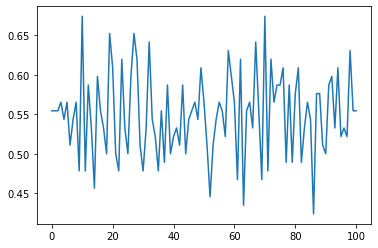

In [14]:
J1_G1_MSI_GC.plot.line()

In [17]:
def GC_base_table(df):
    dt = df.copy()
    grouped = dt.groupby(["Gene","MSIstatus"])
    for name, group in grouped:
        print(name)
        print("_".join(name))
    GC_list = []
    for name, group in grouped:
        subtable = grouped.get_group(name)
        cat_column = subtable.iloc[:,0:101].apply(lambda x: x.str.cat(), axis = 0)
        GC_series = GC_percentage_series(cat_column).rename("_".join(name))
        GC_list.append(GC_series)
    return pd.DataFrame(GC_list).T

In [20]:
J1_bases_to_plot = GC_base_table(J1_bases)
J1_bases_to_plot.head()

('G1', 'MSI-H')
G1_MSI-H
('G1', 'MSS')
G1_MSS
('G2', 'MSI-H')
G2_MSI-H
('G2', 'MSS')
G2_MSS


,G1_MSI-H,G1_MSS,G2_MSI-H,G2_MSS
0,0.554348,0.556291,0.478261,0.417219
1,0.554348,0.437086,0.521739,0.443709
2,0.554348,0.490066,0.347826,0.410596
3,0.565217,0.430464,0.413043,0.450331
4,0.543478,0.549669,0.423913,0.384106


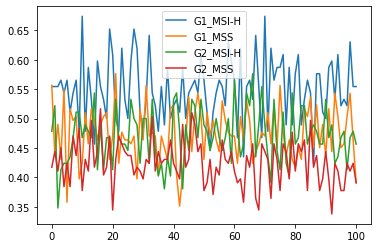

In [21]:
J1_bases_to_plot.plot.line()

## Junction 2 (J2)

In [23]:
J2_IDs = list(SeqIO.index("data_Junction_Regions_CRC_4_19_20_deid_J2.fa","fasta"))
J2_df = pd.DataFrame(SeqIO.parse("data_Junction_Regions_CRC_4_19_20_deid_J2.fa","fasta"))
J2_df.insert(0, "IDs", pd.Series(J2_IDs)) # add "ID" column to the left
J2_df = Split_IDs(J2_df)
J2_bases = J2_df.iloc[:,np.r_[0:101,104:106,107]]
J2_bases_to_plot = GC_base_table(J2_bases)

('G1', 'MSI-H')
G1_MSI-H
('G1', 'MSS')
G1_MSS
('G2', 'MSI-H')
G2_MSI-H
('G2', 'MSS')
G2_MSS


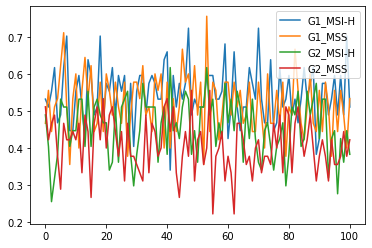

In [24]:
J2_bases_to_plot.plot.line()

In [ ]:
# Save table as RDS and let 